In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
import torch_geometric.transforms as T
import torch_geometric.utils as pyg_utils
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchmetrics.functional import accuracy
from sklearn.manifold import TSNE
from neptune.new.integrations.pytorch_lightning import NeptuneLogger


import lib.data as data
import lib.model as models
from lib.tracing.utils import rel
train_classifier = models.train_classifier
train_regressor = models.train_regressor
print_results = models.print_results

import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

%load_ext autoreload
%autoreload 2

<h1> Experiments for paper

In [2]:
def optimizer(self):
    opt = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.hparams.weight_decay)
#     opt = optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, weight_decay=2e-3)
    sched = {
#         "scheduler": optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5),
        "scheduler": optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=100, T_mult=2),
        "monitor": "train_loss",
        "interval": "epoch",
    }
    return [opt], [sched]

args = {
    'seed': 100,
    "model_name": "GNN",
    "layer_name": "GCN",
    "layer_kwargs": {},
    "task": "node",
    "exp_id": "cora",
    "test_splits": [.2, .2],
    "hidden_dim": 512,
    "num_layers": 3,
    "optim_func": optimizer,
    "epochs": 200,
    'dropout': 0.6,
    'eval_mode': True,
    'ckp_monitor': 'val_acc',
    'ckp_best_k': 1,
    'ckp_patience': 30,
    'gpus': 1,
    'lr': 0.0029,
    'restart': True,
    'draw_node_size': None,
    'precision': 32,
    'nonlin': 'ReLU',
    'weight_decay': 5e0,
    'l1_reg': 1e-4,
    'skip_connect': False,
    'last_fully_adjacent': True,
#     'last_layer_kwargs': dict(train_eps=True),
    'early_stop': True
}

run = trainer_ckp = None
if not args['restart']:
    try:
        trainer_ckp = gnn_trainer.checkpoint_callback.best_model_path
        args['epochs'] *= 2
        run = neptune_logger.run._short_id
    except:
        pass
    
from pytorch_lightning.loggers import CSVLogger
csv_logger = CSVLogger('logs', name='csv_logs')
args['logger'] = csv_logger #True

dataset = data.get_dataset(args['exp_id'])

In [ ]:
# from pytorch_lightning.loggers import NeptuneLogger
from neptune.new.integrations.pytorch_lightning import NeptuneLogger
neptune_logger = NeptuneLogger(
    project='rosso/GNN-Lightning',
    name='-'.join((args['exp_id'], args['model_name'], args['task'])),
    tags=['pytorch-lightning', args['model_name']],
    close_after_fit=False,
    fail_on_exception=True,
    run=run
)
neptune_logger.log_hyperparams(args)

In [3]:
try:
    gnn_model, gnn_result, gnn_trainer = train_classifier(dataset, trainer_ckp=trainer_ckp, **args)
    print_results(gnn_result)
except Exception as e:
    if 'gnn_trainer' in globals() and isinstance(gnn_trainer.logger, NeptuneLogger):
        gnn_trainer.logger.experiment['sys/failed'] = True
    raise e
# Stop logging
finally:
    if 'gnn_trainer' in globals() and hasattr(gnn_trainer.logger.experiment, 'stop'):
        gnn_trainer.logger.experiment.stop()

Global seed set to 100
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No pretrained found, training...



  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.5 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.115     Total estimated model params size (MB)


E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 100
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:322: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_s

E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Train accuracy: 95.00%
Val accuracy:   81.20%
Test accuracy:  81.30%


In [41]:
scores = []
for i in range(10):
    print(f'\n\n=== ITERATION NUMBER: {i} ===\n\n')
    args['seed'] = 100 - i * 4
    try:
        gnn_model, gnn_result, gnn_trainer = train_classifier(dataset, trainer_ckp=trainer_ckp, **args)
        print_results(gnn_result)
        scores.append(gnn_result['test'])
    except Exception as e:
        if isinstance(gnn_trainer.logger, NeptuneLogger):
            gnn_trainer.logger.experiment['sys/failed'] = True
        raise e
    # Stop logging
    finally:
        if hasattr(gnn_trainer.logger.experiment, 'stop'):
            gnn_trainer.logger.experiment.stop()

Global seed set to 100
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs




=== ITERATION NUMBER: 0 ===


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 100


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 96
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)



Train accuracy: 100.00%
Val accuracy:   79.80%
Test accuracy:  78.00%


=== ITERATION NUMBER: 1 ===


No pretrained found, training...


Global seed set to 96


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 92
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Train accuracy: 100.00%
Val accuracy:   79.80%
Test accuracy:  78.40%


=== ITERATION NUMBER: 2 ===


No pretrained found, training...



  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 92


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 88
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Train accuracy: 100.00%
Val accuracy:   79.40%
Test accuracy:  77.60%


=== ITERATION NUMBER: 3 ===


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 88


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 84
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Train accuracy: 100.00%
Val accuracy:   80.00%
Test accuracy:  78.80%


=== ITERATION NUMBER: 4 ===


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 84


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 80
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Train accuracy: 100.00%
Val accuracy:   79.00%
Test accuracy:  78.00%


=== ITERATION NUMBER: 5 ===


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 80


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 76
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Train accuracy: 100.00%
Val accuracy:   80.40%
Test accuracy:  77.80%


=== ITERATION NUMBER: 6 ===


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 76


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 72
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Train accuracy: 98.33%
Val accuracy:   79.20%
Test accuracy:  77.50%


=== ITERATION NUMBER: 7 ===


No pretrained found, training...



  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 72


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 68
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



Train accuracy: 100.00%
Val accuracy:   79.60%
Test accuracy:  76.90%


=== ITERATION NUMBER: 8 ===


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 68


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Global seed set to 64
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Train accuracy: 100.00%
Val accuracy:   79.80%
Test accuracy:  78.40%


=== ITERATION NUMBER: 9 ===


No pretrained found, training...



  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 1.0 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.196     Total estimated model params size (MB)


Global seed set to 64


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Train accuracy: 100.00%
Val accuracy:   79.40%
Test accuracy:  77.60%


In [14]:
dct = {}

In [47]:
import scipy
import numpy as np
mean = np.mean(scores)
std = np.std(scores, ddof=1)
stderr = scipy.stats.sem(scores, ddof=1)
result = f'{mean=}, {std=}, {stderr=}'
dct[args['exp_id'] + '-' + 'GCN'] = result
print(result)
dct

mean=0.779300032567978, std=0.004900123423172958, stderr=0.001549555083316765


{'pubmed-GIN': 'mean=0.7742000122070312, std=0.01151955206279137, stderr=0.005151700296549886',
 'pubmed-SAGE': 'mean=0.7702000319957734, std=0.005116425351794559, stderr=0.0016179557589899073',
 'pubmed-GAT': 'mean=0.7767000336647033, std=0.0040838537780277994, stderr=0.0012914279569651544',
 'pubmed-GCN': 'mean=0.779300032567978, std=0.004900123423172958, stderr=0.001549555083316765'}

<h2> Heat diffusion kernel SVM

In [216]:
beta = 1
lapl_edges, lapl_vals = pyg_utils.get_laplacian(dataset[0].edge_index)
lapl_vals *= -beta
lapl_vals

tensor([ 1.,  1.,  1.,  ..., -1., -1., -1.])

In [ ]:
num_nodes = dataset[0].num_nodes
size = torch.Size([num_nodes, num_nodes])
adj = torch.sparse_coo_tensor(lapl_edges, lapl_vals, size).to_dense().numpy()
expk = scipy.linalg.expm(adj)
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, linear_kernel
expk_rbf = expk + linear_kernel(dataset[0].x)

In [210]:
expk_rbf = expk + rbf_kernel(dataset[0].x)

In [133]:
y = dataset[0].y
train_expk = expk_rbf[dataset[0].train_mask, :][:, dataset[0].train_mask]
test_expk = expk_rbf[dataset[0].test_mask, :][:, dataset[0].train_mask]
y_train = y[dataset[0].train_mask]
y_test = y[dataset[0].test_mask]

In [214]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC(kernel='precomputed', C=42)
svc.fit(train_expk, y_train)
y_pred = svc.predict(test_expk)
y_true = y_test.numpy()
accuracy_score(y_true, y_pred)

0.5

In [12]:
import scipy
import numpy as np
mean = np.mean(scores)
std = np.std(scores, ddof=1)
stderr = scipy.stats.sem(scores, ddof=1)
result = f'{mean=}, {std=}, {stderr=}'
dct[args['exp_id'] + '-' + args['layer_name']] = result
print(result)

mean=0.8077000319957733, std=0.01011105416016347, stderr=0.0031973960691437497


In [13]:
mean = 0.81200
std = 0.01200
stderr = 0.00379
dct['cora-GCN'] = f'{mean=}, {std=}, {stderr=}'

In [14]:
dct

{'cora-GIN': 'mean=0.8077000319957733, std=0.01011105416016347, stderr=0.0031973960691437497',
 'cora-GCN': 'mean=0.812, std=0.012, stderr=0.00379'}

<h1> Random experiments

In [3]:
import lib.data as data
dataset_f = data.get_dataset('MUTAG', largest_component=False, use_gdc=-1)
print(dataset_f.num_node_features, dataset_f.num_classes)
point_f = dataset_f[0]
point_f

7 2


Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

In [4]:
dataset_f[1]

Data(edge_attr=[28, 4], edge_index=[2, 28], x=[13, 7], y=[1])

In [14]:
dataset_f.name

'MUTAG'

In [15]:
l = []
try:
    l.name
except AttributeError:
    print(l)

[]


In [86]:
from torch_geometric.nn import MessagePassing
class ConnectedComponents(MessagePassing):
    def __init__(self):
        super(ConnectedComponents, self).__init__(aggr="max")
    def forward(self, data):
        x = torch.arange(data.num_nodes).view(-1, 1)
        last_x = torch.zeros_like(x)
        while not x.equal(last_x):
            last_x = x.clone()
            x = self.propagate(data.edge_index, x=x)
            x = torch.max(x, last_x)
        unique, perm = torch.unique(x, return_inverse=True)
        perm = perm.view(-1)
        if "batch" not in data:
            return unique.size(0), perm
        cc_batch = unique.scatter(dim=-1, index=perm, src=data.batch)
        return cc_batch.bincount(minlength=data.num_graphs), perm
    def message(self, x_j):
        return x_j
    def update(self, aggr_out):
        return aggr_out
    
from torch_geometric.data import Batch
from torch_geometric.datasets import TUDataset
ds = TUDataset(root='./data/', name='PROTEINS')
data = Batch.from_data_list(ds[:10])
cc = ConnectedComponents()
count, perm = cc(data)
count

tensor([1, 1, 1, 1, 1, 8, 4, 1, 1, 1])

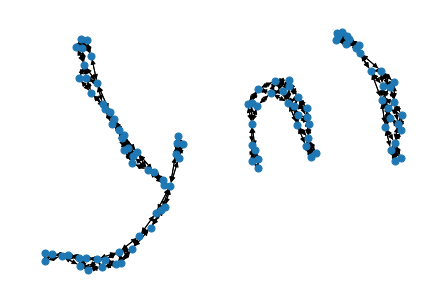

In [20]:
G = pyg_utils.to_networkx(ds[6])
nx.draw(G, node_size=50)

In [19]:
from torch_geometric.data import DataLoader, GraphSAINTRandomWalkSampler
loader = GraphSAINTRandomWalkSampler(dataset[0], batch_size = 10, num_steps=10, sample_coverage=100, walk_length = 3)
for dat in loader:
    print(dat)

Compute GraphSAINT normalization: : 332972it [00:02, 119927.51it/s]                                                    


Data(edge_index=[2, 50], edge_norm=[50], node_norm=[29], test_mask=[29], train_mask=[29], val_mask=[29], x=[29, 3703], y=[29])
Data(edge_index=[2, 50], edge_norm=[50], node_norm=[32], test_mask=[32], train_mask=[32], val_mask=[32], x=[32, 3703], y=[32])
Data(edge_index=[2, 44], edge_norm=[44], node_norm=[30], test_mask=[30], train_mask=[30], val_mask=[30], x=[30, 3703], y=[30])
Data(edge_index=[2, 44], edge_norm=[44], node_norm=[30], test_mask=[30], train_mask=[30], val_mask=[30], x=[30, 3703], y=[30])
Data(edge_index=[2, 46], edge_norm=[46], node_norm=[33], test_mask=[33], train_mask=[33], val_mask=[33], x=[33, 3703], y=[33])
Data(edge_index=[2, 64], edge_norm=[64], node_norm=[34], test_mask=[34], train_mask=[34], val_mask=[34], x=[34, 3703], y=[34])
Data(edge_index=[2, 40], edge_norm=[40], node_norm=[29], test_mask=[29], train_mask=[29], val_mask=[29], x=[29, 3703], y=[29])
Data(edge_index=[2, 52], edge_norm=[52], node_norm=[33], test_mask=[33], train_mask=[33], val_mask=[33], x=[33,

In [16]:
from lib.model import train_classifier, print_results
import lib.model as mod
from lib.tracing.utils import rel
rel(mod)
import torch.optim as optim
def optimizer(self):
    opt = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-2)
#     opt = optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, weight_decay=2e-3)
    sched = {
        "scheduler": optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1),
        "interval": "step",
    }  # called after each training step
    return [opt], [sched]
args = {
    'seed': 53,
    "model_name": "GNN",
    "layer_name": 'GCN',
#     "layer_dict": dict(eps=2, normalize=False),
    'num_layers': 2,
    "task": "graph",
    "test_splits": [.1, .1],
    "hidden_dim": 128,
    "optim_func": optimizer,
    "epochs": 200,
    "dropout": 0.4,
    'gpus': 1,
    'lr': 1e-3,
    'use_edge_attr': False,
    'transform_pre_mp': False,
    "nonlin": "ELU",
    "norm_layer": "LayerNorm",
    'last_fully_adjacent': False
}

model, result, trainer = train_classifier(dataset_f, **args)
print_results(result)

Global seed set to 53
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No pretrained found, training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: saved\MUTAG-GNNClassifier-GCN-graphLevel\lightning_logs

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GNNModel          | 34.7 K
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
34.7 K    Trainable params
0         Non-trainable params
34.7 K    Total params
0.139     Total estimated model params size (MB)


E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 53
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:322: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_st

E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
E:\Anaconda\envs\graph\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Train accuracy: 68.04%
Val accuracy:   78.95%
Test accuracy:  57.89%


In [7]:
rel(data)
n=30
y = np.random.randint(low=0, high=7, size=n)
labels_name = [f'tim-{i}' for i in range(7)]

In [ ]:
dataset = data.get_random_dataset(n=n, p=.08, y=y, largest_component=False, use_gdc=0, seed=32)
c = dataset[0]
c

In [ ]:
c.edge_index

In [161]:
c.edge_index

tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  4,
          4,  5,  5,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 11, 12, 12, 13,
         14, 14, 14, 14, 14, 14, 14, 15, 16, 16, 16, 17, 17, 17, 18, 18, 19, 19,
         20, 20, 21, 21, 21, 21, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26,
         26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29],
        [ 1, 14, 17, 28, 29,  0,  2, 20, 26, 28,  1,  5,  6, 27, 28, 25, 28, 17,
         28,  2,  8, 20,  2, 11, 21, 27,  5, 24, 27, 16, 24, 29,  7, 19, 25, 28,
          0, 16, 21, 22, 24, 26, 28, 23,  9, 14, 26,  0,  4, 23, 21, 26, 12, 27,
          1,  5,  7, 14, 18, 23, 14, 15, 17, 21,  8,  9, 14,  3, 12,  1, 14, 16,
         18,  2,  7,  8, 19, 29,  0,  1,  2,  3,  4, 13, 14,  0,  9, 27]])

In [8]:
c.x.shape

torch.Size([30, 2])

In [4]:
c.edge_attr = torch.ones(c.edge_index.shape[1]) * 2

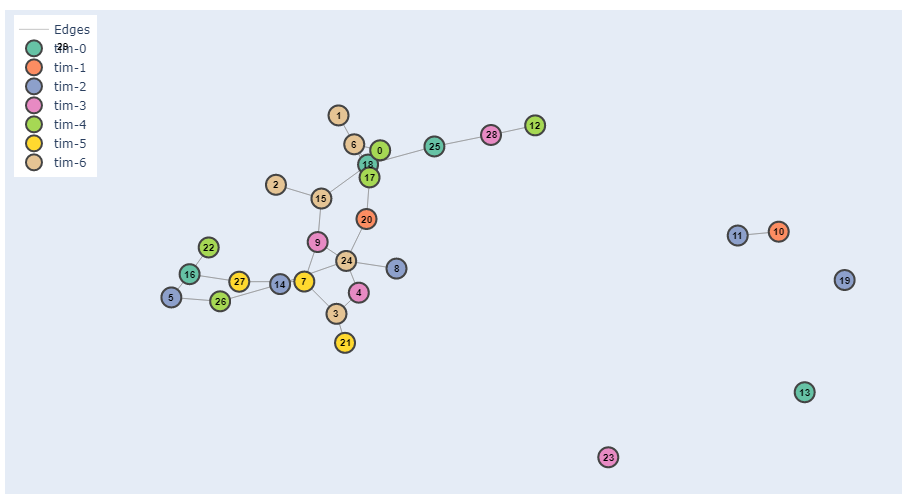

<Figure size 432x288 with 0 Axes>

In [80]:
import networkx as nx
import plotly.tools as tls
from torch_geometric.utils import to_networkx, from_networkx

fig = data.draw(c, plotly=True, labels=True, labels_name=labels_name, degree_size=False, node_size=20,
          figsize=(7,7), with_ids=True, layout_type='spring', seed=34, show=True, legend=True)
fig

In [210]:
def optimizer(self):
    opt = optim.AdamW(self.parameters(), lr=1e-3)
#     opt = optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, weight_decay=2e-3)
    sched = {
        "scheduler": optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20, T_mult=3),
        "interval": "step",
    }  # called after each training step
    return [opt], [sched]
args = {
    'seed': 31,
    "model_name": "GNN",
    "layer_name": 'FAConv',
    "layer_dict": dict(eps=2, normalize=False),
    "task": "node",
    "exp_id": 'ER',
    "test_splits": [.1, .1],
    "hidden_dim": 32,
    "optim_func": optimizer,
    "epochs": 10,
    'gpus': 0,
    'lr': 1e-3,
    'use_edge_attr': True,
    'transform_pre_mp': True,
}

model, result, trainer = train_regressor(dataset, **args)
print_results(result)

Global seed set to 31
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type     | Params
-----------------------------------------
0 | model       | GNNModel | 1.5 K 
1 | loss_module | MSELoss  | 0     
-----------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


No pretrained found, training...


Global seed set to 31



Train accuracy: -176.62%
Val accuracy:   -72.31%
Test accuracy:  -95.15%


<h1> Graph level

In [7]:
tu_dataset = data.get_dataset("MUTAG")
tu_data = tu_dataset.data

In [8]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))
print("Average label: %4.2f" % (tu_dataset.data.y.float().mean().item()))
print(tu_dataset.num_classes)

Data object: Data(edge_attr=[7442, 4], edge_index=[2, 7442], x=[3371, 7], y=[188])
Length: 188
Average label: 0.66
2


In [26]:
torch.unique(tu_data.edge_attr, dim=0)

tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]])

In [11]:
tu_dataset[0]

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

In [42]:
optimizer = (lambda self: optim.AdamW(self.parameters(), lr=1e-2))
args = {
    'seed': 42,
    "exp_id": "MUTAG",
    "model_name": "GNN",
    "layer_name": 'GCN',
#     "layer_args": (2,),
#     "layer_kwargs": dict(aggr='mean'),
    "task": "graph",
    "test_splits": [150, 150],
    "hidden_dim": 64,
    'num_layers': 4,
#     "optim_func": optimizer,
    "epochs": 10,
    'dropout': .1,
    'dropout_head': .4,
    'lr': 1e-4,
    "gpus": 0,
    'use_edge_attr': False,
    'num_edge_features': tu_dataset.data.edge_attr.shape[-1],
    'edge_attr_scaling': False,
    'last_fully_adjacent': False
}
from pytorch_lightning.loggers import CSVLogger
csv_logger = CSVLogger("logs", name='-'.join((args['exp_id'], args['model_name'], args['task'])))
args['logger'] = csv_logger

In [45]:
rel(models)
model, result, trainer = models.train_classifier(tu_dataset, **args)
print_results(result)

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GNNModel          | 17.7 K
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)


No pretrained found, training...


Global seed set to 42



Train accuracy: 70.08%
Val accuracy:   71.05%
Test accuracy:  71.05%


In [ ]:
trainer.logger.experiment.metrics

In [16]:
x = tu_data.x
pyg_utils.dense_to_sparse(torch.ones(x.shape[0], x.shape[0]))[0]

tensor([[   0,    0,    0,  ..., 3370, 3370, 3370],
        [   0,    1,    2,  ..., 3368, 3369, 3370]])

In [10]:
torch.ones(2,2)

tensor([[1., 1.],
        [1., 1.]])

<h1> Load Reality Mining

In [126]:
import scipy.io
reality = scipy.io.loadmat("data/RealityMining/realitymining.mat", struct_as_record=False, squeeze_me=True)

In [39]:
reality.keys()

dict_keys(['__header__', '__version__', '__globals__', 'network', 's'])

In [127]:
import numpy as np
net_data = reality['network']
s = reality['s']
# adjancency matrices
friends = np.nan_to_num(net_data.friends)
in_lab = np.nan_to_num(net_data.lab)
out_lab = np.nan_to_num(net_data.outlab)
# map network elements to survey elements - 1-indexed
net_to_s = net_data.sub_sort
# original mapping is 1-indexed, so we turn it to 0-indexed
net_to_s_0_index = net_to_s - 1
print(net_to_s, net_to_s_0_index, sep='\n')

[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  20  21
  22  23  25  26  27  28  29  30  31  32  33  35  36  37  38  40  41  42
  43  44  46  48  49  50  52  53  54  55  56  57  58  60  61  62  63  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 106 107]
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  35  36  37  39  40  41
  42  43  45  47  48  49  51  52  53  54  55  56  57  59  60  61  62  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 105 106]


In [16]:
import networkx as nx
frg = nx.convert_matrix.from_numpy_matrix(friends)
print(len(frg.nodes), len(frg.edges))
frg.edges(data=True)

94 97


EdgeDataView([(1, 4, {'weight': 1.0}), (1, 5, {'weight': 1.0}), (1, 9, {'weight': 1.0}), (1, 10, {'weight': 1.0}), (1, 19, {'weight': 1.0}), (1, 76, {'weight': 1.0}), (1, 91, {'weight': 1.0}), (2, 19, {'weight': 1.0}), (2, 83, {'weight': 1.0}), (3, 7, {'weight': 1.0}), (3, 12, {'weight': 1.0}), (3, 18, {'weight': 1.0}), (3, 78, {'weight': 1.0}), (4, 4, {'weight': 1.0}), (4, 59, {'weight': 1.0}), (4, 76, {'weight': 1.0}), (5, 19, {'weight': 1.0}), (5, 76, {'weight': 1.0}), (7, 12, {'weight': 1.0}), (7, 22, {'weight': 1.0}), (7, 9, {'weight': 1.0}), (7, 59, {'weight': 1.0}), (9, 9, {'weight': 1.0}), (9, 78, {'weight': 1.0}), (9, 91, {'weight': 1.0}), (11, 50, {'weight': 1.0}), (11, 37, {'weight': 1.0}), (12, 22, {'weight': 1.0}), (14, 56, {'weight': 1.0}), (17, 17, {'weight': 1.0}), (18, 30, {'weight': 1.0}), (19, 19, {'weight': 1.0}), (19, 49, {'weight': 1.0}), (20, 52, {'weight': 1.0}), (20, 83, {'weight': 1.0}), (20, 84, {'weight': 1.0}), (24, 55, {'weight': 1.0}), (24, 59, {'weight':

In [129]:
# FOR NAMED COLUMNS DATA
column = 'my_predictable'
no_answer_to_no_class = True

import pandas as pd

y_raw = [getattr(s[i], column) for i in range(len(s))]
y_raw = list(map(lambda x: (x.lower() if len(x) else 'znan'), y_raw))

class_to_index = dict(zip(sorted(set(y_raw), reverse=True), range(len(set(y_raw)) + 1)))
if no_answer_to_no_class:
    class_to_index['znan'] = max(class_to_index.values())
nan_class = class_to_index['znan']
index_to_class = dict(zip(class_to_index.values(), sorted(class_to_index.keys(), reverse=True)))
print(class_to_index, index_to_class, sep='\n')


## Get classes for all elements in the survey data
y_s = pd.Series(y_raw).map(class_to_index)
print(y_s.values)

## Get classes for the nodes in the network
# the map_to_s contains an erroreneus mapping sub_sort(94)=107, since there are only 106 survey participants
# therefore, only loop within range(len() - 1)
y_net = [y_s[net_to_s_0_index[i]] for i in range(len(net_to_s_0_index) - 1)]
# append 0-class to mark for the 94th element that does not have a correct mapping
y_net.append(nan_class)
y_net = pd.Series(y_net)
print(y_net.values)

{'znan': 3, 'very': 1, 'somewhat': 2, 'not at all': 3}
{3: 'not at all', 1: 'very', 2: 'somewhat'}
[3 3 1 1 2 1 2 1 1 1 3 1 2 3 2 2 1 3 1 2 2 2 1 3 2 1 1 3 2 1 3 2 3 3 1 3 1
 2 3 2 2 3 1 3 3 3 3 3 1 1 3 2 3 2 3 3 3 2 3 1 2 1 3 3 1 1 3 2 3 3 3 3 3 3
 1 3 1 2 3 3 2 2 3 3 3 2 3 1 1 1 3 3 2 3 3 3 1 2 2 3 3 2 2 1 3 1]
[1 1 2 1 2 1 1 1 3 1 2 3 2 2 1 1 2 2 2 1 2 1 1 3 2 1 3 2 3 1 3 1 2 2 2 3 1
 3 3 3 1 1 2 3 2 3 3 3 2 1 2 1 3 1 1 3 2 3 3 3 3 3 3 1 3 1 2 3 3 2 2 3 3 2
 3 1 1 1 3 3 2 3 3 3 1 2 2 3 3 2 2 1 1 3]


In [419]:
# FOR SURVEY DATA -> No class-index mapping inside the data, but available in the documentation
survey_q = 10
no_answer_to_no_class = True

import pandas as pd

q_index = survey_q - 1
# get classes for all nodes in s
y_s = pd.Series([srv_dat[q_index].astype(np.uint8) \
                   if (len(srv_dat := s[i].surveydata) and not np.isnan(srv_dat[q_index])) \
                   else -10 \
                   for i in range(len(s))])
y_s[y_s == -10] = nan_class = max(y_s) if no_answer_to_no_class else 0

print(y_s.values)

index_to_class = {i:i for i in range(10)}

## Get classes for the nodes in the network
# the map_to_s contains an erroreneus mapping sub_sort(94)=107, since there are only 106 survey participants
# therefore, only loop within range(len() - 1)
y_net = [y_s[net_to_s_0_index[i]] for i in range(len(map_to_s) - 1)]
# append 0-class to mark for the 94th element that does not have a correct mapping
y_net.append(nan_class)
y_net = pd.Series(y_net)
print(y_net.values)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [397]:
y_raw[net_to_s_0_index[92]]

'very'

In [396]:
index_to_class[y_s[net_to_s_0_index[92]]]

'very'

In [398]:
index_to_class[y_net[92]]

'very'

dataset=[Data(edge_index=[2, 179], weight=[179], x=[94, 1], y=[94])],
dataset[0].y=tensor([1, 1, 2, 1, 2, 1, 1, 1, 3, 1, 2, 3, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 3,
        2, 1, 3, 2, 3, 1, 3, 1, 2, 2, 2, 3, 1, 3, 3, 3, 1, 1, 2, 3, 2, 3, 3, 3,
        2, 1, 2, 1, 3, 1, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 2, 3, 3, 2, 2, 3,
        3, 2, 3, 1, 1, 1, 3, 3, 2, 3, 3, 3, 1, 2, 2, 3, 3, 2, 2, 1, 1, 3])
dataset.num_classes=94, dataset.num_node_features=1


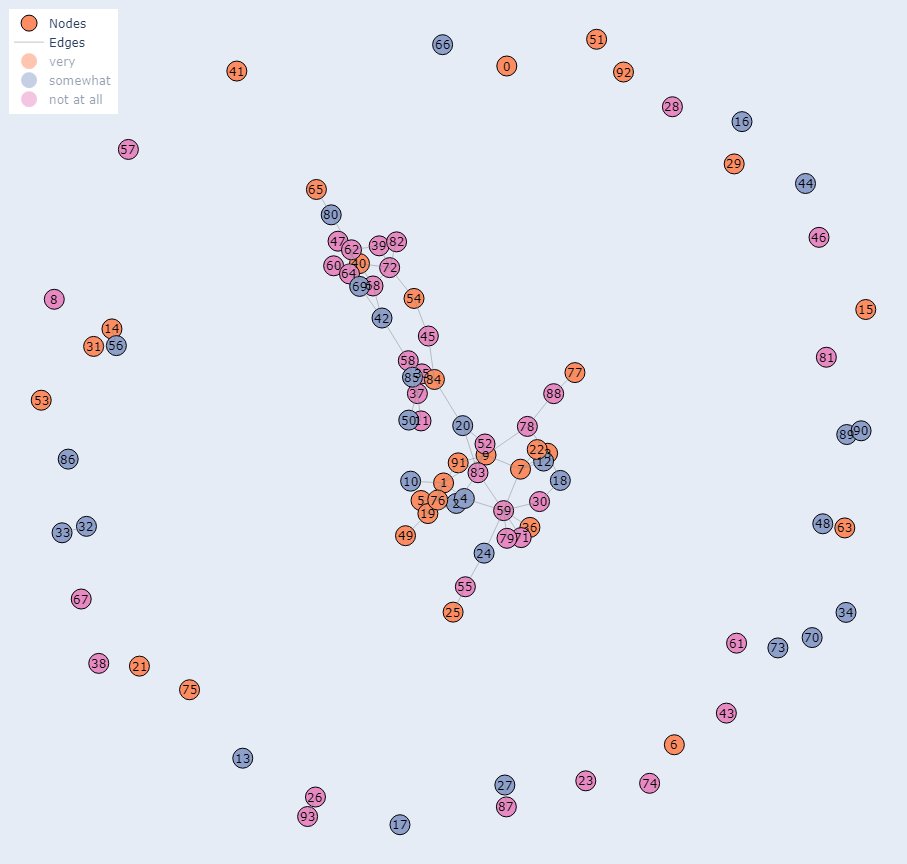

In [130]:
import lib.data as data
dataset = data.get_dataset_from_adj(net_data.friends, y=y_net)
print(f'{dataset=},\n{dataset[0].y=}')
print(f'{dataset.num_classes=}, {dataset.num_node_features=}')
data.draw(dataset[0], layout='graphviz', labels_name=index_to_class, plotly=True, figsize=(12, 12), degree_size=False, node_size=400, seed=3)

In [156]:
def optimizer(self):
    opt = optim.AdamW(self.parameters(), lr=1e-3)
#     opt = optim.SGD(self.parameters(), lr=1e-3, momentum=0.9, weight_decay=2e-3)
    sched = {
        "scheduler": optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=20, T_mult=3),
        "interval": "step",
    }  # called after each training step
    return [opt], [sched]

args = {
    'seed': -1,
    "model_name": "GNN",
    "layer_name": "GCN",
    "task": "node",
    'exp_id': 'reality',
    "test_splits": [.1, .2],
    "hidden_dim": 32,
    'num_layers': 3,
    "optim_func": optimizer,
    "epochs": 150,
    'dropout': .1,
    'dropout_head': .2,
}

In [157]:
model, result, trainer = train_classifier(dataset, **args)
print_results(result)

Global seed set to 2757085366
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 2.4 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


No pretrained found, training...


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 2757085366


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Train accuracy: 69.70%
Val accuracy:   55.56%
Test accuracy:  57.89%
